In [33]:
import os
from pathlib import Path

import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
%matplotlib inline

In [2]:
jsons_dir = Path('../../../data/visual_search_stimuli/json/')

In [3]:
jsons = sorted(
    list(jsons_dir.glob('*.json'))
)
jsons = [str(json_path) for json_path in jsons]

In [4]:
stim_abbrevs = ['RVvGV', 'RVvRHGV', '2_v_5']
alexnet_finetune_jsons = [a_json for a_json in jsons 
                          if any([f'alexnet_{stim_abbrev}' in a_json for stim_abbrev in stim_abbrevs])
                         ]
alexnet_finetune_jsons = sorted(alexnet_finetune_jsons)

In [6]:
data_gz_dir = Path('../../../data/data_prepd_for_nets/')

In [7]:
data_gzs = sorted(
    list(data_gz_dir.glob('*.gz'))
)
data_gzs = [str(data_gz) for data_gz in data_gzs]

In [8]:
alexnet_finetune_data_gzs = [data_gz for data_gz in data_gzs
                             if 'alexnet_finetune' in data_gz]
alexnet_finetune_data_gzs = sorted(alexnet_finetune_data_gzs)

In [34]:
def heatmap(grid, ax=None, vmin=0, vmax=1, cmap='rainbow'):
    """helper function that plots a heatmap,
     using the matplotlib.pyplot.imshow function

    Parameters
    ----------
    grid : numpy.ndarray
        2-dimensional array to plot as a heatmap
    ax : matplotlib.axes.Axes
        axes on which to plot heatmap. If None, then
        a new Axes instance is created

    Returns
    -------
    im : matplotlib.image.AxesImage
        instance returned by call to imshow.
    """
    if ax is None:
        fig, ax = plt.subplots()
    im = ax.imshow(grid, vmin=vmin, vmax=vmax, cmap=cmap)
    return im

In [35]:
def p_item_grid(char_grids, item_char='t', ax=None, return_counts=False):
    """compute probability that item appears within each cell of grid

    Parameters
    ----------
    char_grids : list
        of lists or numpy.ndarrays, each representing a visual search stimulus
        as a grid of characters, where the character in each cell corresponds
        to some item type that can appear in the visual search stimulus.
        The searchstims library saves such a representation of each stimulus it
        generates in the .json metadata file that it saves.
    item_char : str
        Character that represents item for which probability should be computed.
        Default is 't' (for 'target').
    return_counts : bool
        if True, return array with count of number of occurrences of item_char in
        each cell. Default is False.

    Returns
    -------
    p : numpy.ndarray
        of same shape as char_grids, where value of each element is probability
        that item_char occurs in the corresponding cell in char_grids
    counts : numpy.ndarray
        counts used to compute p (by dividing by np.sum(counts)).
        Only returned if return_counts is True
    """
    char_grids = [np.asarray(g) for g in char_grids]

    grid_shape = [g.shape for g in char_grids]
    grid_shape = set(grid_shape)
    if len(grid_shape) == 1:
        grid_shape = grid_shape.pop()
    else:
        raise ValueError(
            'found more than one shape for visual search stimuli grids: '
            f'{grid_shape}'
        )

    counts = np.zeros(grid_shape)
    for g in char_grids:
        # increment by 1 the cell where the item type is found
        # using indices returned by np.nonzero
        counts[np.nonzero(g == item_char)] += 1
    p = counts / np.sum(counts)
    if return_counts:
        return p, counts
    else:
        return p

In [37]:
def p_item_heatmap(json_fname, data_gz_fname, stim_abbrev, set_size=None,
                   data_set='train', item_char='t', vmin=0, vmax=1,
                   ax=None, add_cbar=False):
    """plot heatmap of probability that a specified item appears 
    within each cell of grid, given a dataset of visual searh stimuli
    created by searchstims package

    Parameters
    ----------
    json_fname : str
        path to .json file output by searchstims with target
        and distractor indices from each stimulus file
    data_gz_fname : str
        path to .gz file output by searchnets that has filenames of files in dataset
    stim_abbrev : str
    set_size : int
    data_set : str
        one of {'train', 'val', 'test'}; data set from which heatmap should 
        be generated. Default is 'train'.
    item_char : str
        Character that represents item in grid_as_char.
        Default is 't', for 'target'.
    ax : matplotlib.axes.Axes
        default is None, in which case a new Axes instance is created.

    Returns
    -------
    p : numpy.ndarray
        of same shape as char_grids, where value of each element is probability
        that item_char occurs in the corresponding cell in char_grids    
    im : matplotlib.image.AxesImage
        instance returned by call to imshow.
    """
    if data_set not in {'train',  'val', 'test',}:
        raise ValueError(
            f"data_set must be 'train', 'test', or 'val', but got {data_set}"
        )

    # get filenames of files in dataset, i.e. training set files, test files, etc.,
    # so we can keep only grid_as_char for those files
    data_gz = joblib.load(data_gz_fname)
    stim_fnames = data_gz[f'x_{data_set}']
    if all([type(stim_fname) == str for stim_fname in stim_fnames]):
        stim_fnames = np.asarray(stim_fnames)
    elif all([type(stim_fname) == np.ndarray for stim_fname in stim_fnames]):
        stim_fnames = np.concatenate(stim_fnames)

#    stim_type_vec = data_gz[f'stim_type_vec_{data_set}']
#    if all([type(stim_fname) == str for stim_fname in stim_fnames]):
#        stim_fnames = np.asarray(stim_fnames)
#    elif all([type(stim_fname) == np.ndarray for stim_fname in stim_fnames]):
#        stim_fnames = np.concatenate(stim_fnames)

    # keep just the ones that are the correct visual search stimulus type
#    inds_of_stim = np.nonzero(stim_type_vec == stim_abbrev)
#    import pdb;pdb.set_trace()
#    stim_fnames = stim_fnames[inds_of_stim]
#    stim_fnames = stim_fnames.tolist()
    # keep just name of file, not whole path, 
    # so we can more easily check if each filename from the .json file
    # is in this list of 'just filenames' (without paths)
    stim_fnames = [Path(stim_fname).name for stim_fname in stim_fnames]

    with open(json_fname) as fp:
        stim_meta_dict = json.load(fp)

    stim_meta_dict = stim_meta_dict[stim_abbrev]
    stim_meta_dict = stim_meta_dict[set_size]
    # just concatenate both the 'present' and 'absent' lists
    # and look at all of them, instead of e.g. only keeping
    # target present to look for 't'. In case a different
    # character was used for target and/or distractor type(s)
    stim_meta_list = []
    stim_meta_list.extend(stim_meta_dict['present'])
    stim_meta_list.extend(stim_meta_dict['absent'])

    char_grids = [
        np.asarray(meta_d['grid_as_char'])
        for meta_d in stim_meta_list
        # only keep if filename is in stim_fnames from data_gz
        if Path(meta_d['filename']).name in stim_fnames
    ]

    p = p_item_grid(char_grids, item_char)
    #import pdb;pdb.set_trace()
    im = heatmap(p, ax, vmin=vmin, vmax=vmax)
    return p, im

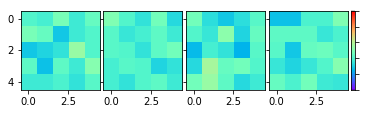

In [38]:
ps = []

fig = plt.figure()
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 4),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for ax_ind, set_size in enumerate([1,2,4,8]):
    set_size = str(set_size)

    p, im = p_item_heatmap(json_fname=alexnet_finetune_jsons[0],
                            data_gz_fname=alexnet_finetune_data_gzs[0],
                            stim_abbrev='2_v_5',
                            set_size=set_size,
                            data_set='train',
                            item_char='t',
                            vmin=0.,
                            vmax=0.1,
                            ax=grid[ax_ind])
    
    ps.append(p)

grid.cbar_axes[0].colorbar(im)

for cax in grid.cbar_axes:
    cax.toggle_label(False)

In [27]:
ps[0]

array([[0.04125, 0.03875, 0.04875, 0.0375 , 0.045  ],
       [0.04875, 0.045  , 0.02875, 0.0375 , 0.04125],
       [0.02875, 0.03125, 0.035  , 0.055  , 0.04125],
       [0.04375, 0.0275 , 0.04375, 0.0375 , 0.05125],
       [0.0375 , 0.0375 , 0.04   , 0.035  , 0.0425 ]])

In [28]:
ps[1]

array([[0.05   , 0.04125, 0.035  , 0.0475 , 0.0325 ],
       [0.0425 , 0.03625, 0.03875, 0.04375, 0.0375 ],
       [0.0425 , 0.04125, 0.035  , 0.04375, 0.0475 ],
       [0.03875, 0.0425 , 0.04125, 0.03125, 0.035  ],
       [0.03875, 0.035  , 0.04125, 0.04375, 0.0375 ]])

In [29]:
ps[3]

array([[0.0275 , 0.0275 , 0.04   , 0.04   , 0.05   ],
       [0.04375, 0.04375, 0.04375, 0.03625, 0.04   ],
       [0.0425 , 0.02875, 0.045  , 0.04625, 0.0425 ],
       [0.03625, 0.03125, 0.03625, 0.04125, 0.05125],
       [0.045  , 0.04   , 0.0475 , 0.0375 , 0.03625]])